# Basic plots of jets and constituents

In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json
import uproot_methods
import copy

In [2]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class CheckJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        pdgid_axis = hist.Bin("pdgid", r"PDG ID", 10000, -5000, 5000)
        eta_axis = hist.Bin("eta", r"$\eta$", 32, -5, 5)
        
        phi_axis = hist.Bin("phi", r"$\phi$", 32, -np.pi, np.pi)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        pt_constituent_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([0,1, 2, 3, 4, 5, 10, 15, 20,25,30]))
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        dr_axis = hist.Bin("dr", r"$\Delta r$", 80, 0, 0.8)
        taunm_axis = hist.Bin("taunm", r"$\tau$", 100, 0, 1)
        
        self._accumulator = processor.dict_accumulator({
            'pt_jet':hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_constituent':hist.Hist("Counts", dataset_axis, pt_constituent_axis),
            'eta_jet':hist.Hist("Counts", dataset_axis, eta_axis),
            'm_jet':hist.Hist("Counts", dataset_axis, m_axis),
            'pdgid':hist.Hist("Counts", dataset_axis, pdgid_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            
            'tau21_jet':hist.Hist("Counts",dataset_axis, taunm_axis),
            'tau31_jet':hist.Hist("Counts",dataset_axis, taunm_axis),
            'tau41_jet':hist.Hist("Counts",dataset_axis, taunm_axis),
            'tau51_jet':hist.Hist("Counts",dataset_axis, taunm_axis),
            'tau61_jet':hist.Hist("Counts",dataset_axis, taunm_axis),
            'tau71_jet':hist.Hist("Counts",dataset_axis, taunm_axis),
            'tau81_jet':hist.Hist("Counts",dataset_axis, taunm_axis),
            'tau32_jet':hist.Hist("Counts",dataset_axis, taunm_axis),

        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        #print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msd=df['jet_msd'],
            tau1=df['jet_tau1'],
            tau2=df['jet_tau2'],
            tau3=df['jet_tau3'],
            tau4=df['jet_tau4'],
            tau5=df['jet_tau5'],
            tau6=df['jet_tau6'],
            tau7=df['jet_tau7'],
            tau8=df['jet_tau8'],
            
            subjet0_pt=df['jet_subjet0_pt'],
            subjet0_eta=df['jet_subjet0_eta'],
            subjet0_phi=df['jet_subjet0_phi'],
            subjet0_m=df['jet_subjet0_m'],
            subjet1_pt=df['jet_subjet1_pt'],
            subjet1_eta=df['jet_subjet1_eta'],
            subjet1_phi=df['jet_subjet1_phi'],
            subjet1_m=df['jet_subjet1_m'],
            ic=df['jet_ic']
            )        
        constituents = JaggedCandidateArray.candidatesfromcounts(
            df['nConstituent'],
            pt=df['constituent_pt'],
            eta=df['constituent_eta'],
            phi=df['constituent_phi'],
            mass=df['constituent_m'],
            pdgid=df['constituent_id'],
            status=df['constituent_status']
            )
        jetptcut = Jets.p4.pt > 200
        tau1 = Jets.tau1[jetptcut].flatten()
        tau2 = Jets.tau2[jetptcut].flatten()
        tau3 = Jets.tau3[jetptcut].flatten()
        tau4 = Jets.tau4[jetptcut].flatten()
        tau5 = Jets.tau5[jetptcut].flatten()
        tau6 = Jets.tau6[jetptcut].flatten()
        tau7 = Jets.tau7[jetptcut].flatten()
        tau8 = Jets.tau8[jetptcut].flatten()
        
        tau21 = np.where( tau1 > 0, tau2/tau1, 0)
        tau31 = np.where( tau1 > 0, tau3/tau1, 0)
        tau41 = np.where( tau1 > 0, tau4/tau1, 0)
        tau51 = np.where( tau1 > 0, tau5/tau1, 0)
        tau61 = np.where( tau1 > 0, tau6/tau1, 0)
        tau71 = np.where( tau1 > 0, tau7/tau1, 0)
        tau81 = np.where( tau1 > 0, tau8/tau1, 0)
        
        tau32 = np.where( tau1 > 0, tau3/tau2, 0)
        
        
        
        
        output['pt_jet'].fill(dataset=dataset,
                            pt=Jets.p4.pt[jetptcut].flatten())
        output['pt_constituent'].fill(dataset=dataset,
                            pt=constituents.p4.pt.flatten())
        output['tau21_jet'].fill(dataset=dataset,
                            taunm=tau21.flatten() )
        output['tau31_jet'].fill(dataset=dataset,
                            taunm=tau31.flatten() )
        output['tau41_jet'].fill(dataset=dataset,
                            taunm=tau41.flatten() )
        output['tau51_jet'].fill(dataset=dataset,
                            taunm=tau51.flatten() )
        output['tau61_jet'].fill(dataset=dataset,
                            taunm=tau61.flatten() )
        output['tau71_jet'].fill(dataset=dataset,
                            taunm=tau71.flatten() )
        output['tau81_jet'].fill(dataset=dataset,
                            taunm=tau81.flatten() )
        output['tau32_jet'].fill(dataset=dataset,
                            taunm=tau32.flatten() )
        output['eta_jet'].fill(dataset=dataset, 
                                 eta=Jets.p4.eta[jetptcut].flatten())        
        output['pdgid'].fill(dataset=dataset, pdgid=constituents.pdgid.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:


fileset={
    #'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_nsj.root'],
    'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_nsj.root'],
    #'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_nsj.root'],
    'QCD':['/mnt/data/ml/qcd_flat15to7000_nsj.root']
}
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=CheckJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers':4, 'flatten': True},
                                  chunksize=5000
                                  
                                 )


elapsed = time.time() - tstart
#print(output)

In [4]:
import matplotlib.pyplot as plt

In [5]:
#for plot in ['tau21_jet', 'pt_jet', 'eta_jet', 'pt_constituent', 'pdgid']:
#
#    fig, ax = hist.plotgrid(output[plot], overlay="dataset", stack=False, density=True
#                                     )
#    for iax in ax.flatten():
#        iax.autoscale(axis='y')
#        iax.set_yscale('log')
#    fig.show()

## N-subjettiness plots

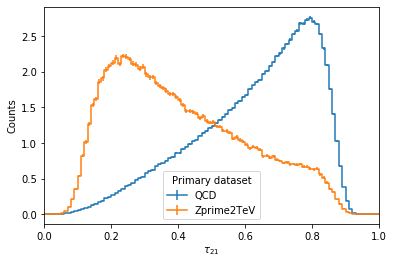

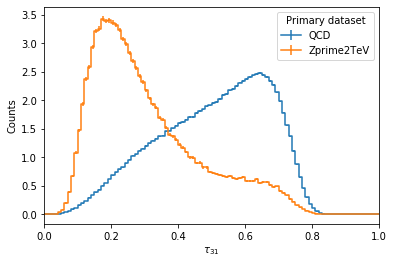

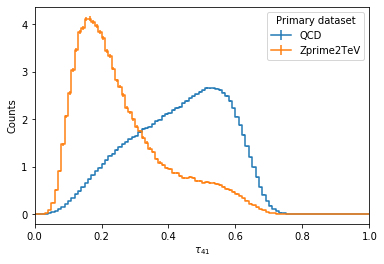

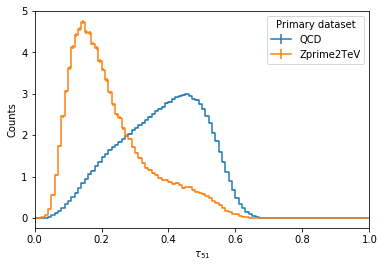

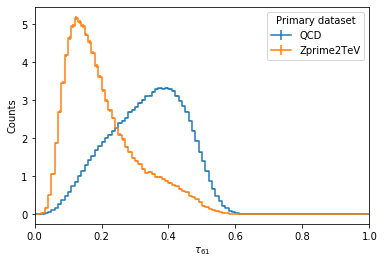

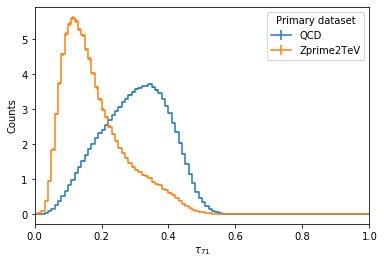

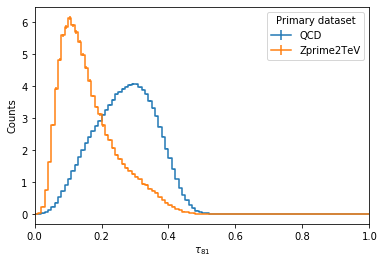

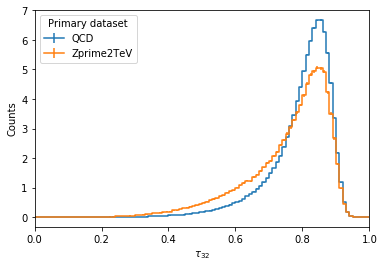

In [6]:
for plot in ['tau21_jet', 'tau31_jet', 'tau41_jet', 'tau51_jet', 'tau61_jet', 'tau71_jet', 'tau81_jet', 'tau32_jet']:
    
    nm = plot[3] +  plot[4]
    fig, ax = hist.plotgrid(output[plot], overlay="dataset", stack=False, density=True
                                     )
    for iax in ax.flatten():
        iax.autoscale(axis='y')
        iax.set_xlabel(r"$\tau_{"+nm+"}$")
        #iax.set_yscale('log')
    fig.show()